In [1]:
import sys
import rospy
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

sys.path.insert(0, '/home/lucas/Documents/EESC_Linux/Drone_project/sarc/SARC2022/python/uav')

from uav import UAV
from sensors.gps import uavGPS
from sensors.camera import uavCamera

In [2]:
uav_t = UAV(node_name='uav_test', uav_id = '0')

[INFO] [1655177912.822646]: UAV0 INIT SUCCEEDED


In [3]:
#BGR -> RGB
def to_rgb(cv_img):
    rgb_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return rgb_img

def img_show(img, title = None):
    
    plt.figure(figsize=(12,8))
    if title is not None:
        plt.title(title)

    plt.imshow(to_rgb(img))

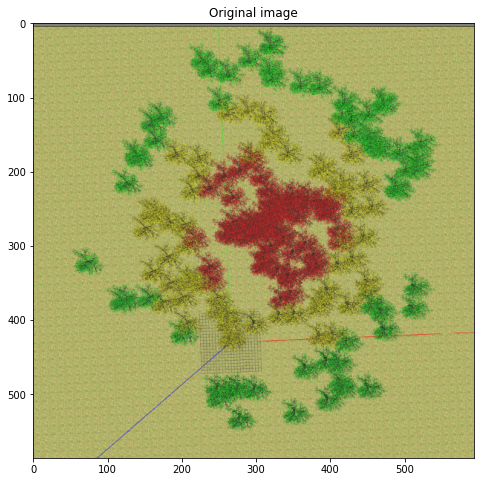

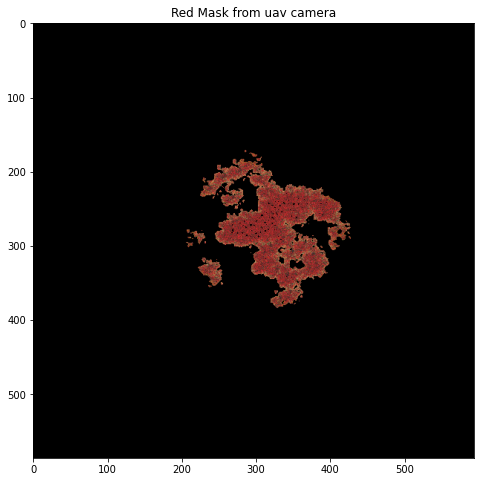

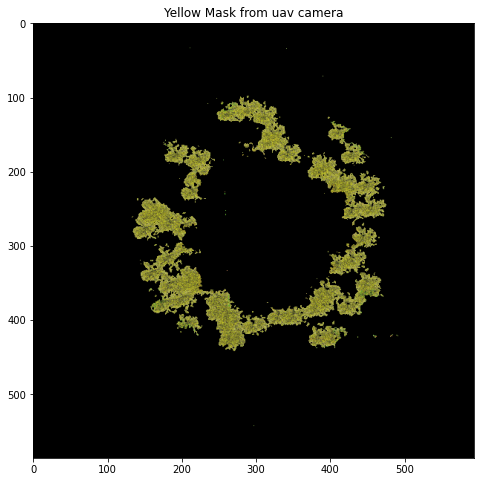

In [34]:
frame = cv2.imread("./scene_01.jpeg")
uav_t.camera.color_detection(img_src = frame)

img_show(frame, "Original image")
img_show(uav_t.camera.cv_img_masked_red, title = 'Red Mask from uav camera')
img_show(uav_t.camera.cv_img_masked_yellow, title = 'Yellow Mask from uav camera')

In [33]:
#bounding box
red_mask = uav_t.camera.mask_red
yellow_mask = uav_t.camera.mask_yellow

xmin, ymin, xmax, ymax = uav_t.camera.bounding_box_vertices(img_mask = red_mask)


xbox_vertices = np.array([xmin, xmin, xmax, xmax])
ybox_vertices = np.array([ymin, ymax, ymin, ymax])

X, Y = uav_t.camera.estimate_3d_coordinates(x_pixel = xbox_vertices,
                                            y_pixel = ybox_vertices,
                                            z_gps = 100)

X_red, Y_red = uav_t.camera.estimate_3d_coordinates(x_pixel = np.nonzero(red_mask)[0],
                                                    y_pixel = np.nonzero(red_mask)[1],
                                                    z_gps = 100)

X_yellow, Y_yellow = uav_t.camera.estimate_3d_coordinates(x_pixel = np.nonzero(yellow_mask)[0],
                                                    y_pixel = np.nonzero(yellow_mask)[1],
                                                    z_gps = 100)

rx = int(0.5*(max(X) - min(X)))
ry = int(0.5*(max(Y) - min(Y)))
r_trajectory = max(rx, ry)   

x0, y0 = uav_t.camera.estimate_3d_coordinates(  x_pixel = uav_t.camera.red_cy,
                                                y_pixel = uav_t.camera.red_cx,
                                                z_gps = 100)

xs_trajectory, ys_trajectory = uav_t.gps.circular_trajectory_pts(x_center = x0,
                                                                y_center = y0,
                                                                radius = r_trajectory,
                                                                num_of_pts = 12)


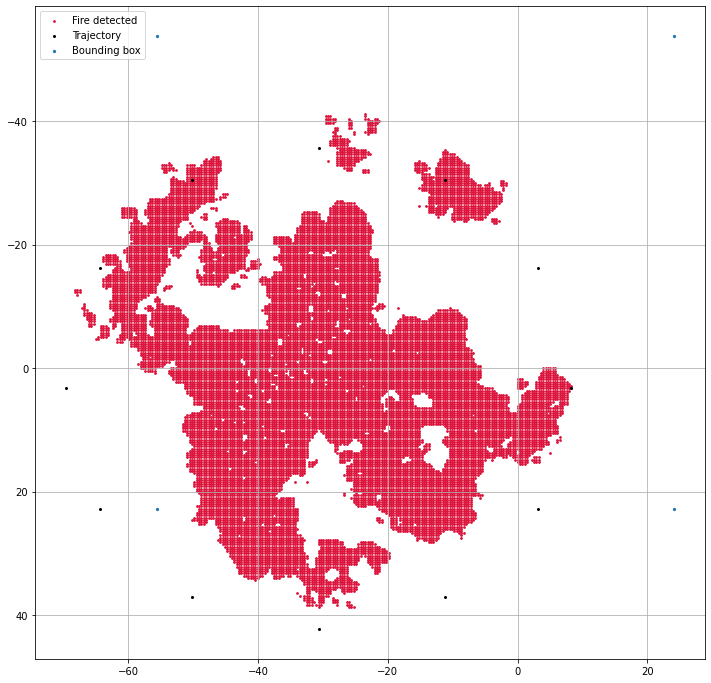

In [38]:
fig2d = plt.figure(figsize = (12,12))
plt.gca().invert_yaxis()

plt.scatter(X_red, Y_red, color = 'crimson', s = 3, label='Fire detected')
plt.scatter(xs_trajectory, ys_trajectory, color = 'black', s = 4, label='Trajectory')
plt.scatter(X, Y, s = 5, label='Bounding box')

plt.grid()
plt.legend()
plt.show()
#! Tá errado isso aqui!

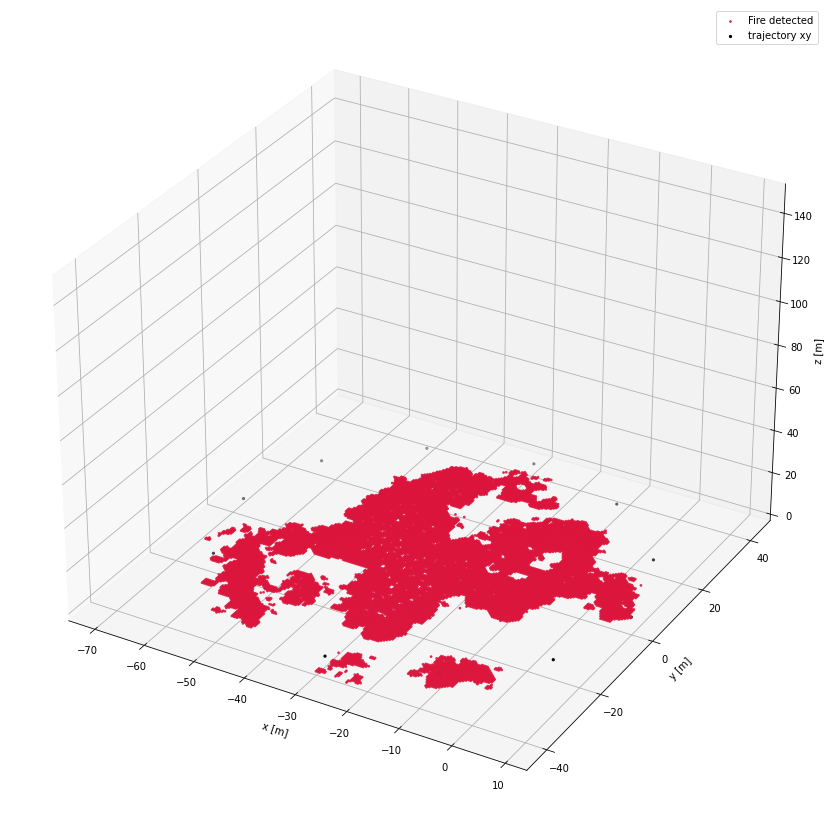

In [23]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

#Fire (red) detected
fire = ax.scatter(X_red, Y_red, np.zeros_like(X_red), c = 'crimson', s = 3, label = 'Fire detected', alpha = 0.8)

#Yellow region
# yellow = ax.scatter(X_yellow, Y_yellow, np.zeros_like(X_yellow), c = 'goldenrod', s = 3, label = 'Yellow region detected')

#Trajectory points
trajectory_pts = ax.scatter(xs_trajectory, ys_trajectory, np.zeros_like(xs_trajectory), c = 'black', s = 5, label = "trajectory xy")

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_zlim([0,150])
plt.legend()
plt.show()